In [3]:
import pandas as pd
import xgboost
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [4]:
df = pd.read_csv("Significant_Features_Preliminary_Cohort1_Heart_C8.csv")

In [5]:
#Prepare Features and Labels

#Filtering for just Group1 and Group3 (change accordingly).
df = df[df['ATTRIBUTE_Group_number'].isin(['Group1', 'Group3'])]

X = df.iloc[:, 5:]  #features start from column 6
y = df['ATTRIBUTE_Group_number']


#Convert categorical target to numeric
#Need to convert our 'Groups' to numeric values, we're using G1 and G3 to see how well they split.
y_encoded = pd.factorize(y)[0]

In [6]:
##Test split. test_size means it trains on 20% of full data.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=123)

In [7]:
##Train Boruta given data, not using label_encoder since XGBoost is endign support for auto. y_encoded is our label encoder.
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:
##Evaluate Model
y_pred = model.predict(X_test)

In [9]:
#Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.375

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.60      0.55         5

    accuracy                           0.38         8
   macro avg       0.25      0.30      0.27         8
weighted avg       0.31      0.38      0.34         8


Confusion Matrix:
 [[0 3]
 [2 3]]


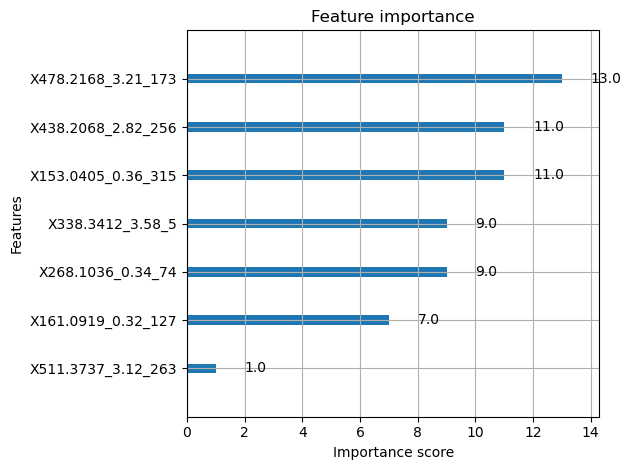

In [10]:
# Plot top 20 most important features
xgboost.plot_importance(model, max_num_features=20)
plt.tight_layout()
plt.show()

In [11]:
###Notes for self#####
#G1 (0) and G3 (1), G1 is only using 1 sample in tests while G3 is using only 4, I need to find out why this is happening.

In [12]:
#Model and cross-validation, this will force training on 4/5 and test on 1/5 of the samples once. 
#I'm attempting to force the samples chosen for testing to be evenly split between group1 and 3.
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(model, X, y_encoded, cv=skf)

print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation scores: [1.   0.8  0.4  0.8  0.75]
Mean accuracy: 0.75


C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

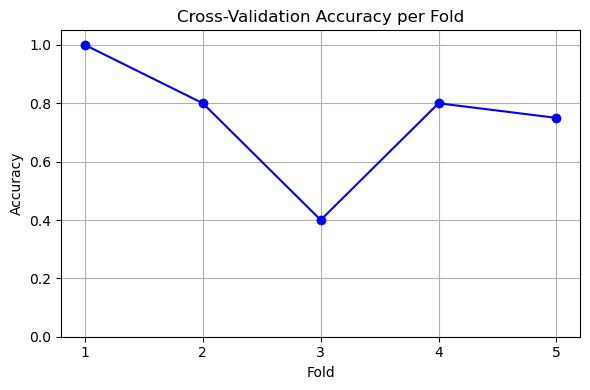

In [13]:
# Plot cross-validation scores
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='blue')
plt.title("Cross-Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)  # keep the scale consistent (0 to 1)
plt.xticks(range(1, len(scores) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
#Will try to run 10 times, to see if we can stabilize. This will be accomplished by keeping the same splits but increasing iterations.
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=123)

scores = cross_val_score(model, X, y_encoded, cv=rskf)
print("All scores:", scores)
print("Mean accuracy:", np.mean(scores))
print("Standard deviation:", np.std(scores))

C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

All scores: [1.   0.8  0.4  0.8  0.75 0.8  1.   0.2  0.8  1.   0.8  1.   0.6  0.6
 0.5  0.8  0.6  0.8  0.6  0.75 0.6  0.2  0.8  0.6  1.   0.8  0.8  0.4
 0.6  0.75 1.   0.6  0.8  0.8  0.5  0.6  0.8  0.4  0.6  0.5  0.6  0.8
 0.6  0.4  0.75 0.6  0.4  1.   0.6  0.5 ]
Mean accuracy: 0.6800000000000002
Standard deviation: 0.2004993765576342


C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\meech\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

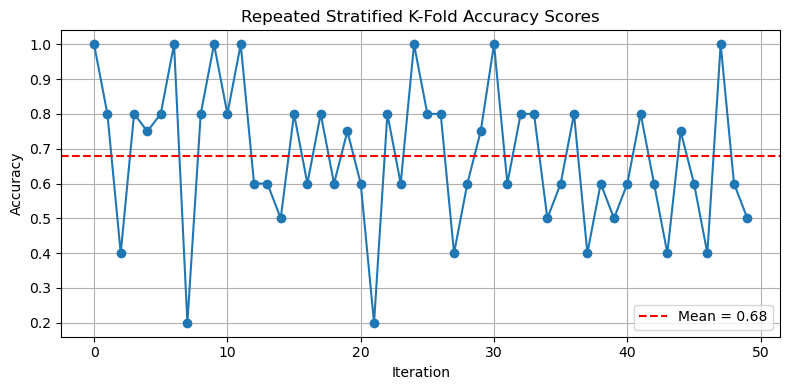

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(scores, marker='o')
plt.axhline(np.mean(scores), color='red', linestyle='--', label=f"Mean = {np.mean(scores):.2f}")
plt.title("Repeated Stratified K-Fold Accuracy Scores")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()